# Figure 1

John Curtin

In [ ]:
# set up environment
options(conflicts.policy = "depends.ok")
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

Open aim 2 analysis data

In [ ]:
version <- "v5"
d <- read_csv(here::here(path_models, str_c("aim_2_", version, ".csv")),
              show_col_types = FALSE) |> 
  mutate(outcome_rct_wk4_num = if_else(outcome_rct_wk4 == "abstinent", 1, 0),
         outcome_rct_wk12_num = if_else(outcome_rct_wk12 == "abstinent", 1, 0),
         outcome_rct_wk26_num = if_else(outcome_rct_wk26 == "abstinent", 1, 0),
         tx_worst = case_when(
           prob_patch < prob_combo_nrt & prob_patch < prob_varenicline ~ "patch",
           prob_combo_nrt < prob_patch & prob_combo_nrt < prob_varenicline ~ "combo_nrt",
           prob_varenicline < prob_patch & prob_varenicline < prob_combo_nrt ~ "varenicline",
           TRUE ~ NA_character_),
         tx_second = case_when(
           tx_worst == "patch" & tx_best == "varenicline" ~ "combo_nrt",
           tx_worst == "patch" & tx_best == "combo_nrt" ~ "varenicline",
           tx_worst == "varenicline" & tx_best == "patch" ~ "combo_nrt",
           tx_worst == "varenicline" & tx_best == "combo_nrt" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "varenicline" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "patch" ~ "varenicline",
           TRUE ~ NA_character_)) |> 
  mutate(tx_rank = case_when(
    tx_rct == tx_best ~ "first",
    tx_rct == tx_second ~ "second",
    tx_rct == tx_worst ~ "third",
    TRUE ~ NA_character_)) |> 
  select(subid, starts_with("tx_"), starts_with("prob_"),
         outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) 

Format data for figure

In [ ]:
# make figure for john's presentation
d_fig <- d |> 
  select(subid, tx_rank, 
         outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) |> 
  pivot_longer(
    cols = c(outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num),
    names_to = "week",
    names_pattern = "(?<=outcome_rct_)(.+)(?=_num)",
    values_to = "outcome_rct_num"
  ) |> 
  mutate(tx_rank = factor(tx_rank, 
                          levels = c("first", "second", "third")),
         week = factor(week,
                       levels = c("wk4", "wk12", "wk26")),
         subid = factor(subid)) |> 
  summarize(outcome_mean = mean(outcome_rct_num), .by = c(tx_rank, week)) 

Make bar chart version

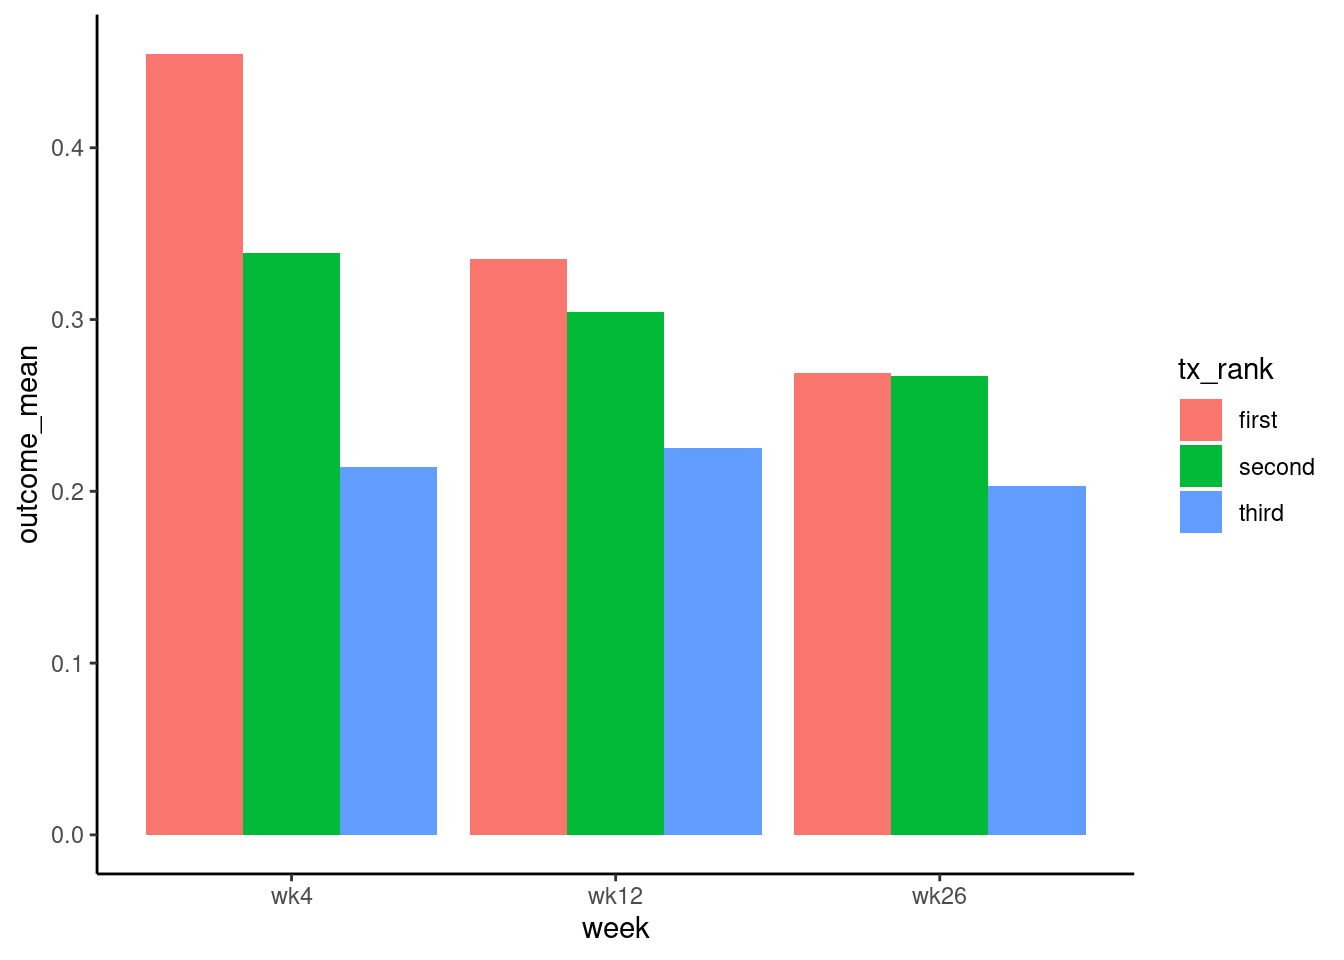

In [ ]:
#| label: fig-bar
#| fig-cap: "Abstince Rate over Time by Tx Rank"

d_fig |> 
  ggplot(aes(x = week, y = outcome_mean, fill = tx_rank)) +
  geom_col(position = "dodge") 

Make line chart version

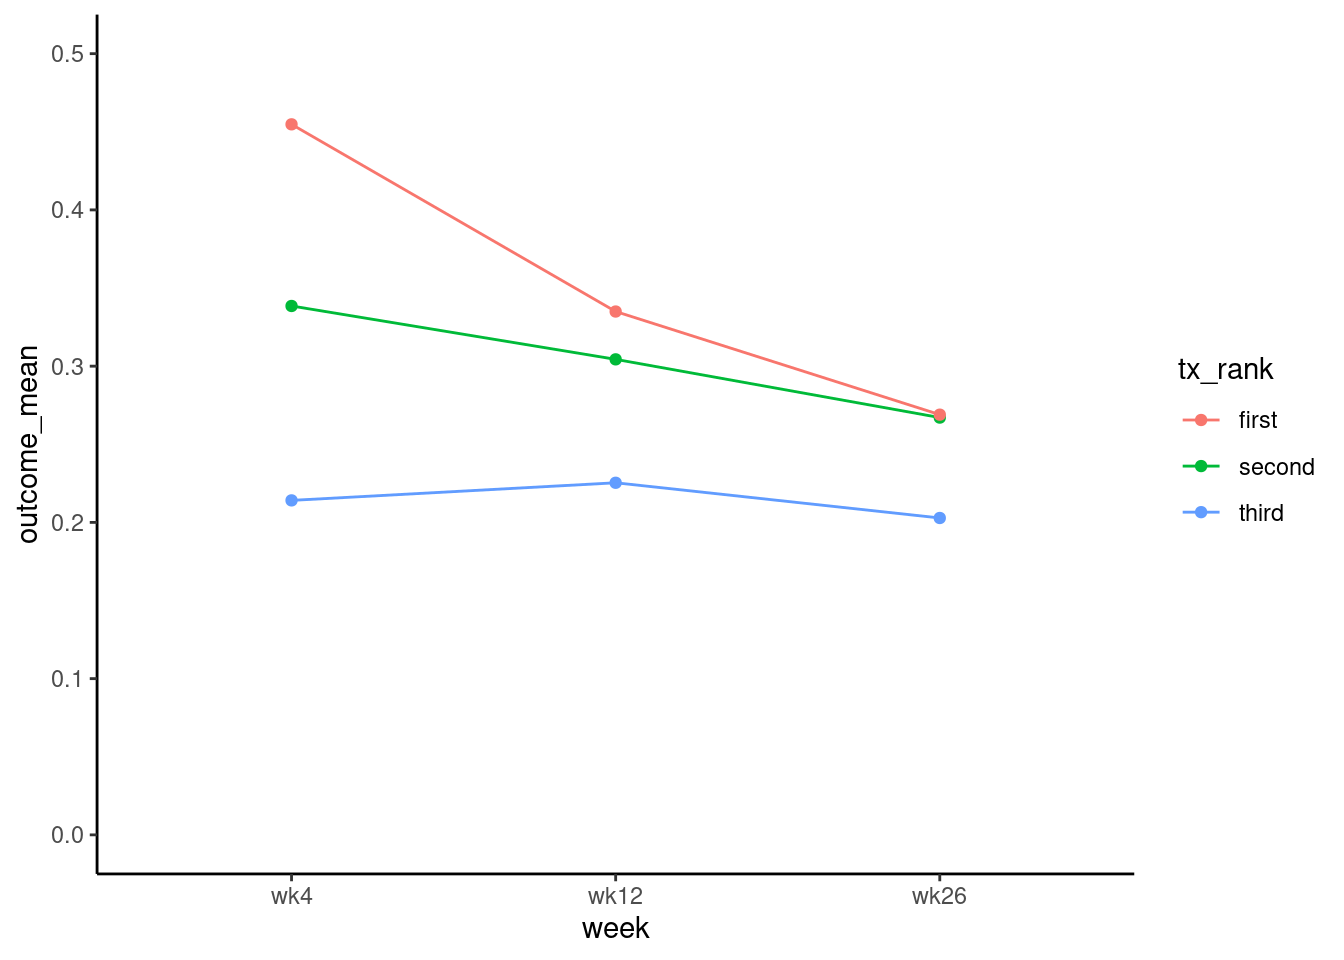

In [ ]:
#| label: fig-line
#| fig-cap: "Abstince Rate over Time by Tx Rank"

d_fig |> 
  ggplot(aes(x = week, y = outcome_mean, color = tx_rank)) +
  geom_line(aes(group = tx_rank)) +
  geom_point() +
  scale_y_continuous(limits = c(0, 0.5))